**Challenges in Representation Learning: Facial Expression Recognition Challenge**

https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data?select=fer2013.tar.gz

 **Easiest way to download kaggle data in Google Colab**
 
 https://www.kaggle.com/general/74235

Other reference data: https://towardsdatascience.com/detecting-facial-features-using-deep-learning-2e23c8660a7a

In [20]:
from google.colab import files
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              234KB  2021-07-23 06:49:54           9671  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5914  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2193  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2471  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In [4]:
! kaggle competitions download -c 'challenges-in-representation-learning-facial-expression-recognition-challenge'

 88% 68.0M/77.3M [00:00<00:00, 183MB/s]
100% 77.3M/77.3M [00:00<00:00, 223MB/s]
 83% 80.0M/96.6M [00:00<00:00, 186MB/s]
100% 96.6M/96.6M [00:00<00:00, 195MB/s]
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 7.41MB/s]
 62% 12.0M/19.3M [00:00<00:00, 124MB/s]
100% 19.3M/19.3M [00:00<00:00, 124MB/s]
 92% 85.0M/92.0M [00:00<00:00, 196MB/s]
100% 92.0M/92.0M [00:00<00:00, 200MB/s]


In [5]:
! mkdir train
! unzip train.csv.zip -d train

Archive:  train.csv.zip
  inflating: train/train.csv         


In [6]:
data = pd.read_csv('train/train.csv')
emotion_map = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
#print(type(emotion_map))
IMG_SIZE = 48

data.head()

X = np.zeros((len(data.pixels), IMG_SIZE, IMG_SIZE, 3))
Y = np.zeros((len(data.pixels), 1))

npDataArray = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(IMG_SIZE, IMG_SIZE, 1).astype('float32'))

for i in range(len(data.pixels)):

  # Append to 3-channel
  X[i][:,:,0] = npDataArray[i][:,:,0]
  X[i][:,:,1] = npDataArray[i][:,:,0]
  X[i][:,:,2] = npDataArray[i][:,:,0]

  Y[i] = int(data.emotion[i])

#print(X)

## Lable Statistics

In [8]:
unique_label, counts = np.unique(Y, return_counts=True)
emotion = [emotion_map[i] for i in unique_label]
print(emotion)
print(counts)

['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
[3995  436 4097 7215 4830 3171 4965]


## Preprocessing

In [9]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from tensorflow.keras.applications.resnet import preprocess_input
X = preprocess_input(X) # preprocess images

Y_onehot = tf.keras.utils.to_categorical(Y, num_classes=7) # one hot encoding

# train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_onehot, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((22967, 48, 48, 3), (5742, 48, 48, 3), (22967, 7), (5742, 7))

## Build Model

In [10]:
# clear graph
tf.keras.backend.clear_session()

In [41]:
# Model 1: Use ResNet as base model
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(base_model.input, predictions)

In [42]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [43]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [44]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint2 = ModelCheckpoint('resnet.h5',
                              monitor='val_loss', 
                              save_weights_only=False, 
                              save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

## Training

In [45]:
logs = model.fit(X_train, Y_train,
                 batch_size=32,
                 epochs=1000,
                 verbose=1,
                 callbacks=[early_stopping, reduce_lr, checkpoint2],     
                 validation_data=(X_test, Y_test))

Epoch 1/1000
718/718 [==============================] - 46s 56ms/step - loss: 1.4765 - accuracy: 0.4548 - val_loss: 1.4717 - val_accuracy: 0.4713


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/1000
718/718 [==============================] - 37s 52ms/step - loss: 1.2138 - accuracy: 0.5447 - val_loss: 1.5435 - val_accuracy: 0.4450
Epoch 3/1000
718/718 [==============================] - 39s 54ms/step - loss: 1.1166 - accuracy: 0.5806 - val_loss: 1.2587 - val_accuracy: 0.5313
Epoch 4/1000
718/718 [==============================] - 42s 58ms/step - loss: 1.0385 - accuracy: 0.6118 - val_loss: 1.4995 - val_accuracy: 0.4949
Epoch 5/1000
718/718 [==============================] - 42s 59ms/step - loss: 1.0066 - accuracy: 0.6243 - val_loss: 1.8130 - val_accuracy: 0.4887
Epoch 6/1000
718/718 [==============================] - 39s 55ms/step - loss: 0.9150 - accuracy: 0.6578 - val_loss: 1.3223 - val_accuracy: 0.5442

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/1000
718/718 [==============================] - 41s 57ms/step - loss: 0.5859 - accuracy: 0.7863 - val_loss: 1.1730 - val_accuracy: 0.6092
Epoch 8/1000
718/718 [====================

In [46]:
history = logs.history

Text(0.5, 1.0, 'accuracy')

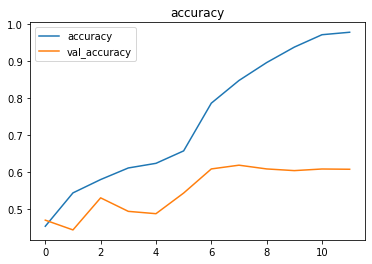

In [47]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

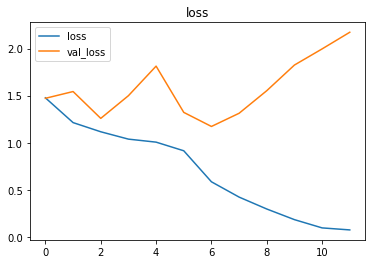

In [48]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [49]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.argmax(Y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)

print(y_true.shape, y_pred.shape)

target_names = [emotion_map[i] for i in range(7)]
print(classification_report(y_true, y_pred, target_names=target_names))

(5742,) (5742,)
              precision    recall  f1-score   support

       anger       0.54      0.51      0.53       841
     disgust       0.71      0.42      0.53        99
        fear       0.46      0.46      0.46       841
   happiness       0.81      0.83      0.82      1403
     sadness       0.47      0.52      0.50       968
    surprise       0.76      0.73      0.75       609
     neutral       0.53      0.53      0.53       981

    accuracy                           0.61      5742
   macro avg       0.61      0.57      0.59      5742
weighted avg       0.61      0.61      0.61      5742



In [50]:
print(confusion_matrix(y_true, y_pred))

[[ 427    4  119   48  125   17  101]
 [  21   42    7    3   22    1    3]
 [ 104    4  389   43  163   67   71]
 [  31    4   32 1170   43   27   96]
 [ 104    2  143   45  504   11  159]
 [  20    1   75   27   17  444   25]
 [  77    2   72  109  190   14  517]]


## Prediction

gt label: [[0. 1. 0. 0. 0. 0. 0.]] 
pred probability: [[3.5726970e-01 6.4045924e-01 2.0769259e-03 8.4905647e-09 1.7970827e-04
  1.3496654e-05 9.4610493e-07]]
gt cls:  disgust
pred cls:  disgust


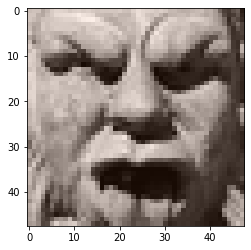

In [61]:
idx = np.random.randint(0, len(X_test))
imgs = X_test[idx:idx+1]
label = Y_test[idx:idx+1]
pred = model.predict(imgs)
print(f'gt label: {label} \npred probability: {pred}')
print('gt cls: ', emotion_map[np.argmax(label)],)
print('pred cls: ',  emotion_map[np.argmax(pred)])

plt.imshow((imgs[0]+127.5)/255) # restore the preprocessed img